## **Active Learning**

This is a very powerful tool which can be used when there is a shortage of labelled data. Active learning can be thought of as a type of 'design methodology' similar to **transfer learning**, which can also be used to leverage small amounts of labelled data.

The main hypothesis in active learning is that if a learning algorithm can choose the data it wants to learn from (usually those examples that can be confusing), it can perform better than traditional methods (passive learning) with substantially less data for training.

An active learning environment includes a learner (the model being trained), huge amount of raw and unlabelled data, and the expert (the person/system labelling the data). The role of the learner is to choose which instances or examples should be labelled. The learner’s goal is to reduce the number of labeled examples needed for an ML model to learn. On the other hand, the expert on receiving the data to be labelled, analyzes the data to determine appropriate labels for it.

adapt to this definiton
https://datascience.stackexchange.com/questions/46602/is-this-approach-for-active-learning-correct?rq=1

There are three types of Active learning scenarios.

* **Query Synthesis** – In such a scenario, the learner constructs examples, which are further sent to the expert for labeling.
* **Stream-based active learning** – Here, from the stream of unlabelled data, the learner decides the instances to be labelled or choose to discard them.
* **Pool-based active learning** – This is the most common scenario in active learning. Here, the learner chooses only the most informative or best instances and forwards them to the expert for labelling.

## **Research**
Active learning is still being researched using different deep learning algorithms such as CNNs and LSTMs, which act as learners in order to improve their efficiency. Also, GANs (Generative Adversarial Networks) are being implemented in the active learning framework. There are also some research papers that try to learn active learning strategies using meta-learning.

## **Applications**

* Natural Language Processing (NLP): Most of the NLP applications require a lot of labelled data such as POS (Parts-of-speech) tagging, NER (Named Entity Recognition), and so on.
* Scene understanding in self-driving cars: Active learning can also be used in detecting objects, such as pedestrians from a video camera mounted on a moving car,a key area to ensure safety in autonomous vehicles.
* Drug designing: Drugs are biological or chemical compounds that interact with specific ‘targets’ in the body (usually proteins, RNA or DNA) with an aim to modify their activity.
* Between others

## **[modAl package](https://github.com/modAL-python/modAL)**

In [ ]:
#!pip install modAl

In [1]:
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor

Here, we shall try to learn the noisy sine function:

In [2]:
#generarting data
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

For active learning, we shall define a custom query strategy tailored to Gaussian processes. In a nutshell, a query stategy in modAL is a function taking (at least) two arguments (an estimator object and a pool of examples), outputting the index of the queried instance and the instance itself. In our case, the arguments are regressor and X.

In [3]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

After setting up the query strategy and the data, the active learner can be initialized.

In [4]:
# assembling initial training set
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

The initial regressor is not very accurate.

The blue band enveloping the regressor represents the standard deviation of the Gaussian process at the given point. Now we are ready to do active learning!

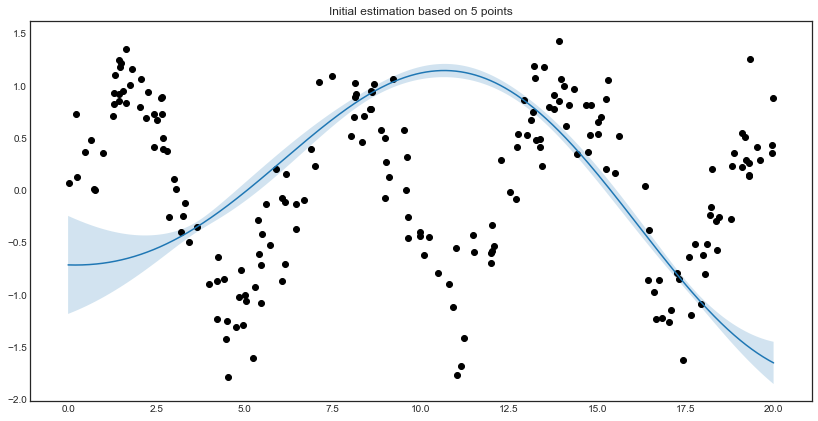

In [5]:
# plotting the initial estimation
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, )-std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Initial estimation based on %d points' % n_initial)
    plt.show()

After a few queries, we can see that the prediction is much improved.

In [6]:
# active learning
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

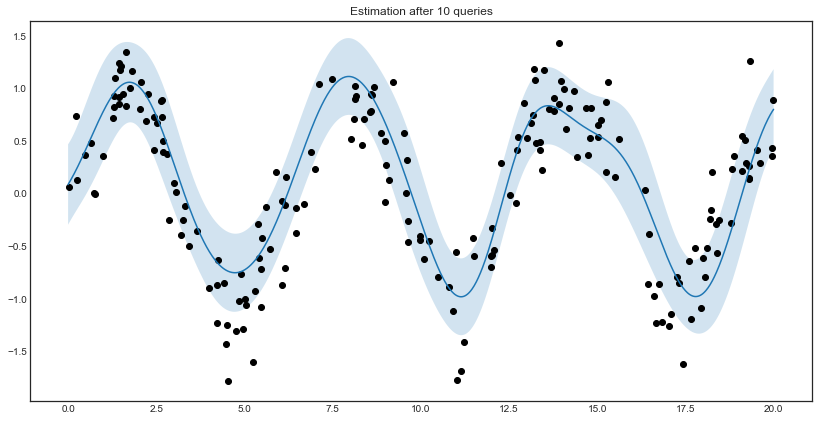

In [7]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, )-std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Estimation after %d queries' % n_queries)
    plt.show()

[More](https://modal-python.readthedocs.io/en/latest/)

## **Multilabel classification**

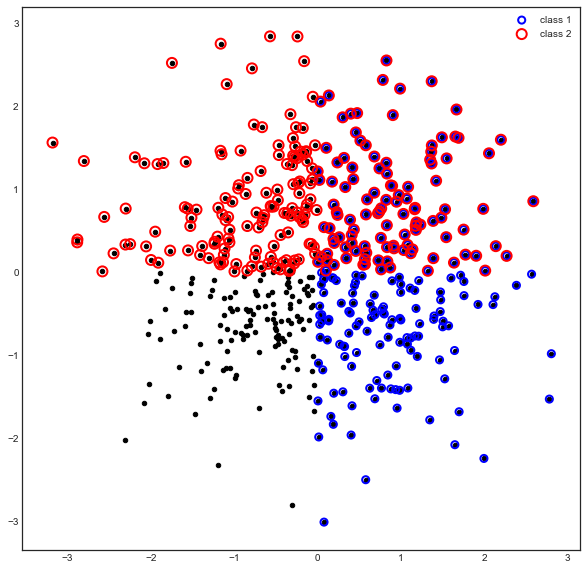

In [8]:

import numpy as np
import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.multilabel import *

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

n_samples = 500
X = np.random.normal(size=(n_samples, 2))
y = np.array([[int(x1 > 0), int(x2 > 0)] for x1, x2 in X])

n_initial = 10
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_initial, y_initial = X[initial_idx], y[initial_idx]
X_pool, y_pool = np.delete(X, initial_idx, axis=0), np.delete(y, initial_idx, axis=0)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.scatter(X[:, 0], X[:, 1], c='k', s=20)
    plt.scatter(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1],
                facecolors='none', edgecolors='b', s=50, linewidths=2, label='class 1')
    plt.scatter(X[y[:, 1] == 1, 0], X[y[:, 1] == 1, 1],
                facecolors='none', edgecolors='r', s=100, linewidths=2, label='class 2')
    plt.legend()
    plt.show()

learner = ActiveLearner(
    estimator=OneVsRestClassifier(SVC(probability=True, gamma='auto')),
    query_strategy=avg_score,
    X_training=X_initial, y_training=y_initial
)

query_idx, query_inst = learner.query(X_pool)
learner.teach(X_pool[query_idx], y_pool[query_idx])

## **[libact](https://libact.readthedocs.io/en/latest/)**